In [1]:
'''Retrieve all inputs executed in the current kernel section'''
%history

'''Retrieve all inputs executed in the current kernel section'''
%history


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import squarify

import warnings

In [3]:
print('Pandas version -> %s' % pd.__version__)
print('Numpy version -> %s' % np.__version__)

Pandas version -> 2.1.2
Numpy version -> 1.26.1


In [4]:
df_sales_data = pd.read_csv('sales_data_cleaned.csv', index_col='Unnamed: 0',
                                    dtype={  'InvoiceDate': 'string',
                                             'InvoiceMonth': 'category',
                                             'DayPart': 'category',
                                             'InvoiceNo': 'category',
                                             'CustomerID': 'string',
                                             'Country': 'category',
                                             'StockCode': 'category',
                                             'Quantity': 'int64',
                                             'UnitPrice': 'float64',
                                             'Revenue': 'float64'},
                                    parse_dates=['InvoiceDate'])

In [5]:
df_sales_data.head()

,InvoiceDate,InvoiceMonth,DayPart,InvoiceNo,CustomerID,Country,StockCode,Quantity,UnitPrice,Revenue
0,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,85123A,6,2.55,15.30
1,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,71053,6,3.39,20.34
2,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84406B,8,2.75,22.00
3,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84029G,6,3.39,20.34
4,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84029E,6,3.39,20.34


In [6]:
df_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392688 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceDate   392688 non-null  datetime64[ns]
 1   InvoiceMonth  392688 non-null  category      
 2   DayPart       392688 non-null  category      
 3   InvoiceNo     392688 non-null  category      
 4   CustomerID    392688 non-null  string        
 5   Country       392688 non-null  category      
 6   StockCode     392688 non-null  category      
 7   Quantity      392688 non-null  int64         
 8   UnitPrice     392688 non-null  float64       
 9   Revenue       392688 non-null  float64       
dtypes: category(5), datetime64[ns](1), float64(2), int64(1), string(1)
memory usage: 21.4 MB


In [7]:
#color palette to keep the following plots harmonic

colors = sns.color_palette("tab20", 20)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [8]:
#segmentando a base de dados
df_cohort = df_sales_data.query('InvoiceMonth != "2011-12"')[['CustomerID']].copy()

In [9]:
#extraindo o mês a partir da data
df_cohort['VisitMonth'] = df_sales_data['InvoiceDate'].dt.to_period('M')

In [10]:
#determinando qual o primeiro mês no qual o usuário visitou o site
df_cohort['Cohort'] = df_cohort.groupby('CustomerID')['VisitMonth'].transform('min')

In [11]:
#Save a copy to keep the CustomerID
df_cohort_customers = df_cohort.copy()

In [12]:
#agrupando os usuários por mês e data da visita
df_cohort = df_cohort.groupby(['Cohort', 'VisitMonth']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)

In [13]:
#calculando o quantos periodos se passaram entre uma visita e a primeira visita
from operator import attrgetter

df_cohort['PeriodNumber'] = (df_cohort.VisitMonth - df_cohort.Cohort).apply(attrgetter('n'))
df_cohort_customers['PeriodNumber'] = (df_cohort_customers.VisitMonth - df_cohort_customers.Cohort).apply(attrgetter('n'))

In [14]:
df_cohort.drop('VisitMonth',axis=1,inplace=True)
df_cohort_customers.drop('VisitMonth',axis=1,inplace=True)

In [15]:
#criando a matrix de retenção
cohort_pivot = df_cohort.pivot_table(index='Cohort', columns='PeriodNumber', values='n_customers')

cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

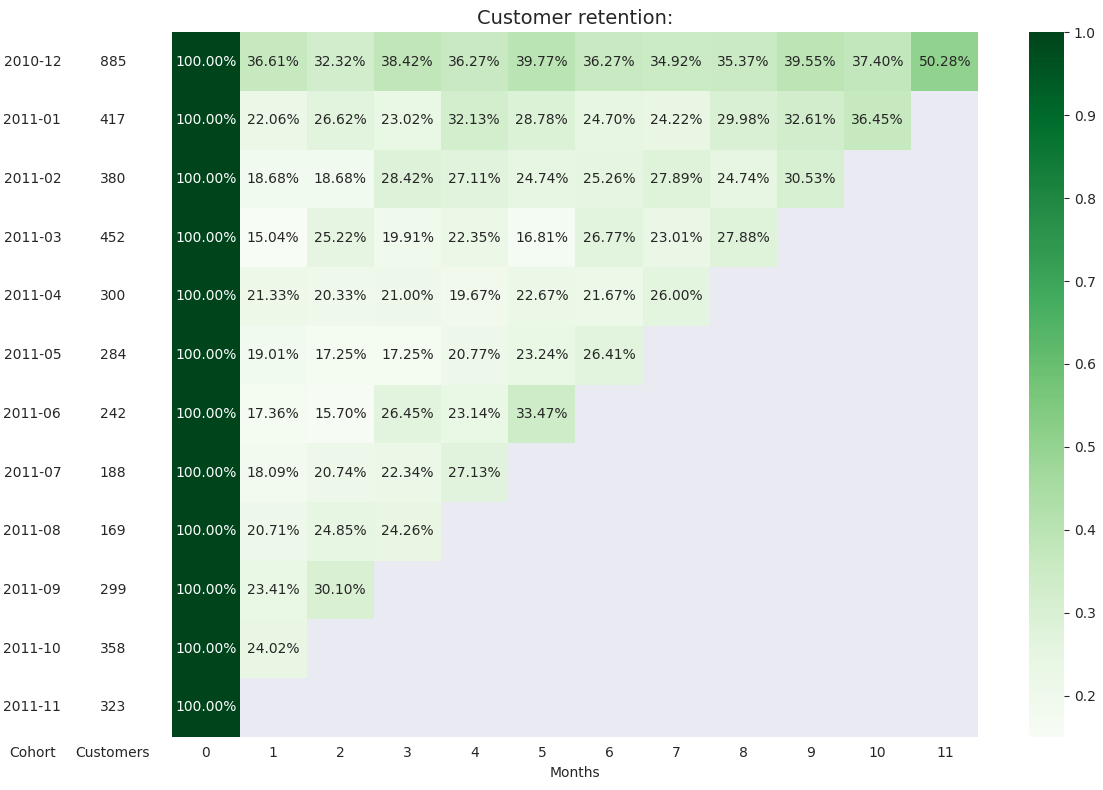

In [16]:
#plotando a matrix de retenção
import matplotlib.colors as mcolors

with sns.axes_style("dark"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 12]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.2%', 
                cmap='Greens', 
                ax=ax[1])
    ax[1].set_title('Customer retention:', fontsize=14)
    ax[1].set(xlabel='Months',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'Customers'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])
       
    ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation = 0, fontsize = 10)
    ax[0].set_ylabel('Cohort', rotation=0, fontsize=10)
    ax[0].yaxis.set_label_coords(-0.45,-0.033)
    fig.tight_layout()

In [36]:
#Selected a relevant segment of customers
#Here, we want to send a survey to the customers from cohort 2010-12 who had returned on 2011-11
#50% of that cohort have returned there and we have an opportunity to ask them why to understand the customers better

df_cohort_customers['Cohort'] = df_cohort_customers['Cohort'].astype(str)
df_cohort_customers.drop_duplicates(inplace=True)

customers_cohort201012_period11 = df_cohort_customers.query('Cohort == "2010-12" & PeriodNumber==11')['CustomerID'].to_frame()
customers_cohort201012_period11.head()

,CustomerID
431696,17419
431735,14911
431825,13758
431900,17377
431925,13327


In [33]:
#Relative amount of customers selected
total_customers = df_cohort_customers['CustomerID'].nunique()
selected_customers = customers_cohort201012_period11['CustomerID'].nunique()

ratio = selected_customers / total_customers

print(f' Total customers: {total_customers:,} \n',
      f'Selected customers: {selected_customers:,} \n',
       'Selected customers relative amount: %2.2f %%'  % (ratio*100))

 Total customers: 4,297 
 Selected customers: 445 
 Selected customers relative amount: 10.36 %


In [35]:
#export the customers ids to a csv file so we can use it on marketing campaings
customers_cohort201012_period11.to_csv('customers_cohort201012_period11.csv', index=False)